# (10/28/20) Data Loaders for ML Pipelines

In part 1 of this blog, we looked at python methods, generators, and iterators for lazy data reading. 

In this blog post, we will combine these tools and build something a little more involved: Effecient data objects for preparation and data ingestion into ML models!

We will look at the holodec data (as of Oct 12, 2020), which contains large hologram images and numerical data accompaning each image. The holodec data is saved as netCDF format – by default the data type only supports lazy reading!

In [5]:
from holodecml.data import *
import time

The main method to load the data is reproduced here (which calls other methods, not shown) 

In [2]:
def load_raw_datasets(path_data, num_particles, split, output_cols, subset):
    ds = open_dataset(path_data, num_particles, split)
    if subset:
        ix = int(subset * ds['image'].shape[0])
        inputs = ds['image'][:ix].values
        outputs = ds[output_cols].to_dataframe()
        outputs = outputs[outputs["hid"] < (ix+1)]
    else:
        inputs = ds["image"].values
        outputs = ds[output_cols].to_dataframe()    
    ds.close()
    return inputs, outputs

For most data files, there is nothing wrong with this method -- its compact, easy to read, and does what you want it to do. As we have seen with the file loading example above, methods quickly become memory inefficient once files become large in size.

In [8]:
path_data = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/"
num_particles = "multi"
split = 'train'
subset = False
output_cols = ["x", "y", "z", "d", "hid"]

In [10]:
t0 = time.time()
inputs, outputs = load_raw_datasets(path_data, num_particles, split, subset, output_cols)
t1 = time.time()
print(t1-t0)

250.0281355381012


This file is pretty large! Not large enough to cause a memory overflow, but it still takes about 4 to 5 minuites to load. 

Let us first write a lazy reader that returns the same thing data as the above method, but one row at a time. Then we will utilize special iterable objects from the Torch, Tensorflow, and Keras libraries that will enable multiprocessing with multiple simultanous workers for creating batches as well as other transformations.

### The Dataset Reader

In [11]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from torch.utils.data import Dataset, DataLoader

Torch.utils.data.Dataset and tensorflow.keras.utils.Sequence objects both require a custom "Reader" class to contain the $\color{blue}{\textbf{__len__}}$ and $\color{blue}{\textbf{__getitem__}}$ thunder methods:

In [12]:
class HologramReader(Dataset): # Sequence
    
    'Generates data for Keras/Tensorflow/Torch environments'
    
    def __init__(self, 
                 path_data, 
                 num_particles, 
                 split, 
                 output_cols, 
                 subset, 
                 maxnum_particles = 100):
        
        'Initialization'
        self.ds = open_dataset(path_data, num_particles, split)
        self.output_cols = [x for x in output_cols if x != 'hid']        
        self.hologram_numbers = list(range(len(self.ds.hologram_number.values)))
        self.maxnum_particles = maxnum_particles
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.hologram_numbers)
    
    def __getitem__(self, idx):
        'Return one row of data'
        
        # Select one "row" from the dataset
        hologram = self.hologram_numbers[idx]

        x_out = self.ds["image"][hologram].values
        y_out = np.zeros((
            self.maxnum_particles if self.maxnum_particles else self.num_particles, 
            len(self.output_cols)
        ))
        particles = np.where(self.ds["hid"] == hologram + 1)[0]
        for l, p in enumerate(particles):
            for m, col in enumerate(self.output_cols):
                y_out[l, m] = self.ds[col].values[p]

        return x_out, y_out

In [13]:
data_reader = HologramReader(path_data, num_particles, split, output_cols, subset)

The method $\color{blue}{\textbf{__getitem__}}$ is used to select whichever hologram we want (take the one labeled 0):

In [14]:
x, y = data_reader.__getitem__(0)

In [15]:
print(x.shape, y.shape)

(600, 400) (100, 4)


Make a quick plot:

In [16]:
import matplotlib.pyplot as plt

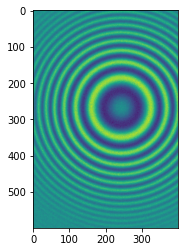

In [17]:
plt.imshow(x)

### The Iterator

##### Torch

To make the the torch/keras Reader class iterable, we can wrap a torch DataLoader object around it which will enable batching, multiprocessing capabilities, and other options. As noted, the DataLoader object requires that the Reader class contains the $\color{blue}{\textbf{__len__}}$ and $\color{blue}{\textbf{__getitem__}}$ thunder methods:

In [18]:
data_iterator = DataLoader(
    data_reader,
    num_workers = 8,
    batch_size = 32,
    shuffle = True
)

In [19]:
for (x, y) in data_iterator:
    print(x.shape, y.shape)
    break

torch.Size([32, 600, 400]) torch.Size([32, 100, 4])


The DataLoader object will take care of creating independent workers that each will load the Reader and put the row data onto a queue where the data is sent back to a Manager that feeds the model. The first few calls to data_iterator will be slow as the workers have to be initialized before they can start putting data onto a queue.

In a future blog post we will write our own multiprocessing worker class, but lets appreciate how easy the big three libraries have made it for us to get to this point.

##### Keras


When training a model with Keras, all we have to do is swap $\color{black}{\textbf{HologramReader(Dataset)}}$ for $\color{black}{\textbf{HologramReader(Sequence)}}$ and make no other changes. We also could have skipped using the inheritance approach and specify the output type (torch tensor versus numpy tensor) upon return.

In older Keras versions, the Reader would be fed into the Model.fit_generator method, which allowed one to toggle the number of workers and queue size. Now that functionality has been added to the Model.fit method while Model.fit_generator has been depcrecated. The important bit about the Sequence object is that it is thread-safe, meaning the workers spawned will not duplicate data chunks (this isn't necessarily always a problem but depends on the type of data being used).

The torch DataLoader came with shuffle capability (by initializing a random order using the $\color{blue}{\textbf{__len__}}$ method), whereas in the Sequence object, shuffle functionality (and whatever else you want) can be enabled by adding a method typically called $\color{blue}{\textbf{on_epoch_end}}$ that will shuffle after some number of data points have been returned. 

##### Tensorflow

Tensorflow also has its own library of data objects. We only have to make a few adjustments to the above Readers to use the tf variant where the call will be a generator and not a method:

In [20]:
class TFHologramReader: 
    
    'Generates data for Keras/Tensorflow/Torch environments'
    
    def __init__(self, 
                 path_data, 
                 num_particles, 
                 split, 
                 output_cols, 
                 subset, 
                 maxnum_particles = 100):
        
        'Initialization'
        self.ds = open_dataset(path_data, num_particles, split)
        self.output_cols = [x for x in output_cols if x != 'hid']        
        self.hologram_numbers = list(range(len(self.ds.hologram_number.values)))
        self.maxnum_particles = maxnum_particles
    
    def __call__(self):
        'Return one row of data'
        for k, hologram in enumerate(self.hologram_numbers):
            # Select one "row" from the dataset
            x_out = self.ds["image"][hologram].values
            y_out = np.zeros((
                self.maxnum_particles if self.maxnum_particles else self.num_particles, 
                len(self.output_cols)
            ))
            particles = np.where(self.ds["hid"] == hologram + 1)[0]
            for l, p in enumerate(particles):
                for m, col in enumerate(self.output_cols):
                    y_out[l, m] = self.ds[col].values[p]

            yield tf.convert_to_tensor(x_out), tf.convert_to_tensor(y_out)

Note that this Reader's $\color{blue}{\textbf{__call__}}$ is a generator, whereas before we used a method.

Calling and using the reader is the same as before. First, initialize an instance by setting the input variables:

In [21]:
tf_data_generator = TFHologramReader(
    path_data, num_particles, split, output_cols, subset
)

Then we wrap Tensorflow's Dataset object around the generator, using the $\color{blue}{\textbf{from_generator}}$ method within the Dataset object, and setting the tensor types explictly:

In [22]:
tf_data_iterator = tf.data.Dataset.from_generator(
    tf_data_generator, 
    (tf.dtypes.float32, tf.dtypes.float32)
)

Setting the batch size is accomplished by this call:

In [23]:
tf_data_iterator = tf_data_iterator.batch(32)

Shuffling is a little more complex. Since a generator is used and there is not len thunder method, a memory buffer of size buffer_size will be created and rows put into it. Then, batches are selected from it and returned. Note that there could be a delay in the begining as the buffer has to fill up:

In [24]:
tf_data_iterator = tf_data_iterator.shuffle(buffer_size=100)

To get true random sampling, the buffer size would need to be the size of the data set.

In torch and Keras examples, we explicitly specified the total number of holograms that could be queried from the dataset, which allowed for easily performing true random sampling. We could just as easily build this into the tf reader as well, for example, by adding an on_epoch_end method that shuffles the hologram numbers after the generator yields a fixed number of data points. We get the same output as before but now with tensorflow tensors:

In [25]:
for (x, y) in tf_data_iterator:
    print(x.shape, y.shape)
    break

(32, 600, 400) (32, 100, 4)


The number of workers can be set when training the model through the Model.fit in newer versions of Keras as:

In [26]:
Model.fit(
    tf_data_iterator,
    ...,
    max_queue_size=32, 
    workers=8, 
    use_multiprocessing=True
)

We could use any of these approaches with either ML language, though the torch and tensorflow versions are supported while Sequence has been deprecated. Enabling multiprocessing with Tensorflow Data objects is rather tricky though, we just let the Keras methods handle that here. We will cover that another time!

Note that these special iterator objects contain many other features not covered here, so be sure to check out the documentation!

Tensorflow Dataset: [https://www.tensorflow.org/api_docs/python/tf/data/Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Torch Dataset: [https://pytorch.org/docs/stable/data.html](https://pytorch.org/docs/stable/data.html)

Feel free to email me (John Schreck, schreck@ucar.edu) with any questions / mistakes / whatever!